### 文件读取

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import matplotlib.font_manager as fm
import platform
import os

# 根据操作系统设置合适的中文字体
system = platform.system()
if system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'PingFang HK', 'Apple Color Emoji']
elif system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun']
else:  # Linux或其他
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'WenQuanYi Zen Hei']

# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

print(f"当前操作系统: {system}")
print(f"当前字体设置: {plt.rcParams['font.sans-serif']}")

# 定义路径
parent_dir = "生成结果"
sub_dir = "last_quadrant"
sub_dir_path = os.path.join(parent_dir, sub_dir)

# 先确保父目录存在
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)
    print(f"已创建目录: {parent_dir}")

# 检查子目录是否存在，如果不存在则创建
if not os.path.exists(sub_dir_path):
    os.makedirs(sub_dir_path)
    print(f"已创建子目录: {sub_dir_path}")
else:
    print(f"子目录已存在: {sub_dir_path}")

当前操作系统: Windows
当前字体设置: ['SimHei', 'Microsoft YaHei', 'SimSun']
已创建子目录: 生成结果\last_quadrant


In [2]:
import os
import glob

# 自动搜索"生成结果/matches_analysis/"文件夹下符合模式的文件
matches_analysis_dir = "生成结果/matches_analysis/"
voc_data_files = glob.glob(os.path.join(matches_analysis_dir, "*_功能场景匹配象限分析_完整列表.txt"))
if voc_data_files:
    voc_data_path = voc_data_files[0]  # 使用找到的第一个匹配文件
else:
    voc_data_path = None
    print("未找到匹配的VOC数据文件")

# 自动搜索"生成结果/social_media/"文件夹下的文件
social_media_dir = "生成结果/social_media/"
social_media_files = glob.glob(os.path.join(social_media_dir, "View-归一化的模型结果.txt"))
if social_media_files:
    social_media_model_path = social_media_files[0]
else:
    social_media_model_path = None
    print("未找到匹配的社交媒体模型结果文件")

# 打印找到的文件路径
if voc_data_path:
    print(f"找到VOC数据文件: {voc_data_path}")
if social_media_model_path:
    print(f"找到社交媒体模型文件: {social_media_model_path}")

# 读取VOC数据（TXT格式）
def read_voc_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()

        # 检查文件是否表明没有找到数据（扩展检查条件）
        if "没有找到任何" in content and ("功能-场景匹配数据" in content or "场景匹配" in content):
            print("VOC数据文件中没有找到任何场景匹配数据")
            # 返回一个带有预期列但无数据的DataFrame
            return pd.DataFrame(columns=[
                '象限', '排名', '场景匹配', '重要性分数', '提及频率', 
                '文本质量', '最终得分', '综合得分'
            ])

        # 提取各象限的数据
        quadrants = []

        # 匹配四个象限区域
        quadrant_pattern = r'## (第[一二三四]象限[^#]*?)(?=\n\n## |$)'
        quadrant_matches = re.findall(quadrant_pattern, content, re.DOTALL)
        
        if not quadrant_matches:
            print("未能在文件中找到象限数据区域")
            # 检查文件是否包含一些我们需要处理的特殊标记
            if "## 第一象限" in content or "## 第二象限" in content:
                print("文件包含象限标记，但格式可能不匹配，尝试备用解析方式")
            
            # 返回空DataFrame
            return pd.DataFrame(columns=[
                '象限', '排名', '场景匹配', '重要性分数', '提及频率', 
                '文本质量', '最终得分', '综合得分'
            ])

        for quadrant_content in quadrant_matches:
            # 提取象限标题
            title_match = re.match(r'(第[一二三四]象限[^\n]*)', quadrant_content)
            quadrant_title = title_match.group(1) if title_match else "未知象限"

            # 尝试两种可能的模式匹配
            # 模式1：原始格式
            defect_pattern1 = r'(\d+)\. (.*?)\n\s+重要性分数: ([\d\.]+), 提及频率: ([\d\.]+), 文本质量: ([\d\.]+), 最终得分: ([\d\.]+), 综合得分: ([\d\.]+)'
            # 模式2：可能的备用格式，处理科学记数法和括号格式
            defect_pattern2 = r'(\d+)\. (.*?)\n\s+重要性分数: ([\d\.]+), 提及频率: ([\d\.e\-]+), 文本质量: ([\d\.]+)[\n\s]+最终得分: ([\d\.]+) \(综合得分: ([\d\.]+)\)'
            
            # 先尝试第一种模式
            defect_matches = re.findall(defect_pattern1, quadrant_content)
            
            # 如果第一种模式没有匹配，尝试第二种模式
            if not defect_matches:
                defect_matches = re.findall(defect_pattern2, quadrant_content, re.DOTALL)
                
            if not defect_matches and '共有' in quadrant_content:
                print(f"在 {quadrant_title} 中找到'共有'标记但无法匹配场景匹配项目")

            for defect in defect_matches:
                # 根据匹配到的模式处理数据
                if len(defect) == 7:  # 第一种模式
                    index, name, importance, frequency, quality, final_score, total_score = defect
                else:  # 第二种模式
                    index, name, importance, frequency, quality, final_score, total_score = defect
                
                quadrants.append({
                    '象限': quadrant_title,
                    '排名': int(index),
                    '场景匹配': name.strip(),
                    '重要性分数': float(importance),
                    '提及频率': float(frequency),
                    '文本质量': float(quality),
                    '最终得分': float(final_score),
                    '综合得分': float(total_score)
                })

        # 创建DataFrame
        voc_data = pd.DataFrame(quadrants)
        
        if len(voc_data) == 0:
            print("解析完成但未找到任何场景匹配项目数据")
        else:
            print(f"成功读取VOC数据，共{len(voc_data)}条记录")
            
        return voc_data
    except Exception as e:
        print(f"读取VOC数据失败: {e}")
        # 返回空DataFrame作为默认值
        return pd.DataFrame(columns=[
            '象限', '排名', '场景匹配', '重要性分数', '提及频率', 
            '文本质量', '最终得分', '综合得分'
        ])

# 读取社交媒体模型结果
def read_social_media_model(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        
        # 使用正则表达式提取表格内容
        pattern = r'\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|'
        matches = re.findall(pattern, content)
        
        # 创建DataFrame
        if matches and len(matches) > 2:  # 确保有足够的行（标题行、分隔行、数据行）
            # 跳过标题行和分隔行
            data = []
            for match in matches:
                # 跳过表头分隔行 (|---|---|)
                if not all('-' in item for item in match):
                    data.append(match)
            
            # 去掉表头
            if len(data) > 1:
                columns = ['变量', '变量类型', '系数', 'p值', '归一化系数', '归一化百分比', '显著性']
                df = pd.DataFrame(data[1:], columns=columns)  # 跳过第一行作为标题
                
                # 处理数值列
                df['系数'] = df['系数'].astype(float)
                df['p值'] = df['p值'].astype(float)
                df['归一化系数'] = df['归一化系数'].astype(float)
                df['归一化百分比'] = df['归一化百分比'].str.rstrip('%').astype(float)
                
                print(f"成功读取社交媒体模型结果，共{len(df)}条记录")
                return df
        
        print("未能从文件中提取有效内容")
        return None
    except Exception as e:
        print(f"读取社交媒体模型结果失败: {e}")
        return None

# 读取数据
voc_data = read_voc_data(voc_data_path)
social_media_model = read_social_media_model(social_media_model_path)

# 显示数据概览
if voc_data is not None:
    print("\nVOC数据概览:")
    print(voc_data.head())
    print("\nVOC数据统计:")
    print(voc_data.groupby('象限').size())
    
if social_media_model is not None:
    print("\n社交媒体模型结果概览:")
    print(social_media_model.head())
    print("\n显著变量:")
    print(social_media_model[social_media_model['显著性'] == '是'])

找到VOC数据文件: 生成结果/matches_analysis\致欧-2025-01-10之后VOC数据_功能场景匹配象限分析_完整列表.txt
找到社交媒体模型文件: 生成结果/social_media/View-归一化的模型结果.txt
VOC数据文件中没有找到任何场景匹配数据
成功读取社交媒体模型结果，共2条记录

VOC数据概览:
Empty DataFrame
Columns: [象限, 排名, 场景匹配, 重要性分数, 提及频率, 文本质量, 最终得分, 综合得分]
Index: []

VOC数据统计:
Series([], dtype: int64)

社交媒体模型结果概览:
                     变量  变量类型      系数      p值  归一化系数  归一化百分比 显著性
0              层高可调节性表达   自变量  0.4666  0.0037    1.0   100.0   是
1  author_followers_cnt  控制变量  0.0000  0.0000    0.0     0.0   是

显著变量:
                     变量  变量类型      系数      p值  归一化系数  归一化百分比 显著性
0              层高可调节性表达   自变量  0.4666  0.0037    1.0   100.0   是
1  author_followers_cnt  控制变量  0.0000  0.0000    0.0     0.0   是


### 建立痛点与社媒变量的关联关系

In [3]:
import os
import json
import pandas as pd
from openai import OpenAI
from time import sleep

os.environ["DASHSCOPE_API_KEY"] = "sk-2ea9416b45e04af6b6aa72d3c2ade52f"

In [4]:
def configure_openai_client():
    """配置OpenAI客户端连接到阿里云百炼"""
    import os
    from openai import OpenAI
    
    api_key = os.getenv("DASHSCOPE_API_KEY")
    if not api_key:
        # 如果环境变量中没有设置API密钥，请在此处设置
        api_key = "YOUR_API_KEY"  # 请替换为您的实际API密钥
        print("警告: 使用代码中的API密钥，建议通过环境变量设置")
    
    client = OpenAI(
        api_key=api_key,
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    )
    return client

# 使用qwen-max模型映射痛点到社媒变量
def map_matches_to_variables(matches, social_media_variables, client):
    """
    使用qwen-max模型将痛点映射到相关的社交媒体变量
    
    Args:
        matches: 产品功能与场景匹配描述
        social_media_variables: 可用的社交媒体变量列表
        client: OpenAI客户端
    
    Returns:
        dict: 变量与关联强度的映射
    """
    import json
    from time import sleep
    
    # 构建提示词
    prompt = f"""
    你是一个产品分析专家。请分析以下产品功能与消费者使用场景之间的关联关系:
    
    产品功能场景匹配: "{matches}"
    
    可选的消费者行为变量:
    {", ".join(social_media_variables)}
    
    请分析这个产品缺陷/痛点与哪些消费者行为变量最相关，并给出关联强度(0-1之间的浮点数)。
    只返回JSON格式，结构如下:
    {{
        "变量名1": 关联强度,
        "变量名2": 关联强度,
        ...
    }}
    
    请只选择最相关的2-4个变量，并按关联强度从高到低排序。
    """
    
    # 设置最大重试次数
    max_retries = 3
    retry_count = 0
    retry_delay = 2  # 初始重试延迟(秒)
    
    while retry_count < max_retries:
        try:
            # 调用qwen-max模型
            completion = client.chat.completions.create(
                model="qwen-max",  # 使用qwen-max模型
                messages=[
                    {'role': 'system', 'content': 'You are a helpful assistant specializing in product analysis.'},
                    {'role': 'user', 'content': prompt}
                ],
                response_format={"type": "json_object"}
            )
            
            # 解析返回结果
            response_content = completion.choices[0].message.content
            result = json.loads(response_content)
            return result
        
        except json.JSONDecodeError as e:
            # JSON解析错误，可能是返回格式不正确
            print(f"JSON解析错误 (尝试 {retry_count+1}/{max_retries}): {e}")
            print(f"API返回内容: {response_content if 'response_content' in locals() else 'N/A'}")
            
            retry_count += 1
            if retry_count < max_retries:
                print(f"等待 {retry_delay} 秒后重试...")
                sleep(retry_delay)
                retry_delay *= 2  # 指数退避策略
            
        except Exception as e:
            # 其他API错误
            print(f"API调用错误 (尝试 {retry_count+1}/{max_retries}): {e}")
            
            retry_count += 1
            if retry_count < max_retries:
                print(f"等待 {retry_delay} 秒后重试...")
                sleep(retry_delay)
                retry_delay *= 2  # 指数退避策略
    
    # 所有重试都失败，返回默认值
    print(f"错误: 映射痛点 '{pain_point}' 失败，所有重试都失败，使用默认值")
    if "价格敏感度" in social_media_variables:
        return {"价格敏感度": 0.8, "设计审美偏好": 0.6}
    else:
        # 使用列表中的前两个变量作为默认值
        defaults = {}
        for var in social_media_variables[:2]:
            defaults[var] = 0.7 if var == social_media_variables[0] else 0.5
        return defaults


def analyze_sentiment_with_huggingface(texts):
    """
    使用Hugging Face的预训练模型分析文本情感强度
    
    Args:
        texts: 需要分析的文本列表
    
    Returns:
        list: 情感得分列表，范围在0-1之间
    """
    try:
        from transformers import pipeline
        
        print("正在加载情感分析模型...")
        # 加载情感分析模型
        sentiment_analyzer = pipeline(
            "sentiment-analysis", 
            model="distilbert-base-uncased-finetuned-sst-2-english",
            device=-1  # 使用CPU；如果有GPU可用，可以设为0或其他适当值
        )
        print("模型加载完成，开始分析文本情感...")
        
        # 批量处理文本
        results = []
        batch_size = 16  # 设置适当的批处理大小
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            print(f"处理文本批次 {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1}")
            
            # 处理文本长度限制问题
            processed_texts = []
            for text in batch_texts:
                # 截断过长的文本
                if len(text) > 512:
                    processed_text = text[:512]
                else:
                    processed_text = text
                processed_texts.append(processed_text)
            
            batch_results = sentiment_analyzer(processed_texts)
            
            for res in batch_results:
                # 使用模型的置信度分数作为情感强度
                sentiment_score = res["score"]
                results.append(sentiment_score)
        
        print(f"情感分析完成，共处理{len(texts)}条文本")
        return results
    
    except ImportError as e:
        print(f"警告: 无法导入transformers模块 - {e}")
        print("将使用随机值代替情感分析结果")
        # 如果无法导入transformers，使用随机值作为替代
        import random
        return [random.uniform(0.5, 1.0) for _ in range(len(texts))]
    
    except Exception as e:
        print(f"情感分析过程中发生错误: {e}")
        print("将使用随机值代替情感分析结果")
        import random
        return [random.uniform(0.5, 1.0) for _ in range(len(texts))]

### 计算坐标值

In [5]:
def establish_matches_relationships(voc_data, social_media_model):
    """
    使用qwen-max模型建立功能场景匹配度与社媒变量的关联关系
    
    Args:
        voc_data: 包含产品功能场景匹配的DataFrame
        social_media_model: 包含社交媒体变量的DataFrame
    
    Returns:
        DataFrame: 包含场景匹配度与社媒变量关联关系的DataFrame
    """
    import pandas as pd
    from time import sleep
    
    # 配置OpenAI客户端
    try:
        client = configure_openai_client()
    except ImportError as e:
        print(f"警告: 无法导入OpenAI模块 - {e}")
        print("将使用预定义的默认值进行分析")
        client = None
    
    # 获取可用的社交媒体变量列表
    social_media_variables = social_media_model['变量'].tolist()
    
    # 为每个痛点创建关联关系
    matches_relationships = []
    
    # 处理所有记录
    for idx, row in voc_data.iterrows():            
        matches = row['场景匹配']
        print(f"处理痛点: {matches}")
        
        # 使用qwen-max模型进行映射
        if client:
            variable_mappings = map_matches_to_variables(matches, social_media_variables, client)
        else:
            # 如果没有客户端，使用预定义的默认值
            variable_mappings = {"价格敏感度": 0.8, "设计审美偏好": 0.6}
        
        # 为每个映射创建一条记录
        for variable, association_strength in variable_mappings.items():
            if variable in social_media_model['变量'].values:
                var_row = social_media_model[social_media_model['变量'] == variable].iloc[0]
                transmission_coef = abs(float(var_row['归一化系数']))
                
                matches_relationships.append({
                    'matches': matches,
                    'variable': variable,
                    'association_strength': float(association_strength),
                    'transmission_coef': transmission_coef
                })
        
        # 添加短暂延迟，避免API调用过于频繁
        if client:
            sleep(0.5)
    
    # 转换为DataFrame
    relationships_df = pd.DataFrame(matches_relationships)
    
    # 如果结果为空，添加一些默认值
    if len(relationships_df) == 0:
        print("警告: 未能建立任何痛点与社媒变量的关联关系，使用默认值")
        for idx, row in voc_data.iterrows():
            matches = row['场景匹配']
            default_variables = social_media_variables[:2] if social_media_variables else ["设计审美偏好", "价格敏感度"]
            
            for i, variable in enumerate(default_variables):
                if variable in social_media_model['变量'].values:
                    var_row = social_media_model[social_media_model['变量'] == variable].iloc[0]
                    transmission_coef = abs(float(var_row['归一化系数']))
                    
                    matches_relationships.append({
                        'matches': matches,
                        'variable': variable,
                        'association_strength': 0.8 if i == 0 else 0.6,
                        'transmission_coef': transmission_coef
                    })
        
        relationships_df = pd.DataFrame(matches_relationships)
    
    return relationships_df

def calculate_coordinates(voc_data, relationships_df):
    # 准备存储计算结果的DataFrame
    results = voc_data.copy()
    
    # 使用Hugging Face模型分析情感强度
    sentiment_scores = analyze_sentiment_with_huggingface(results['场景匹配'].tolist())
    results['情感得分'] = sentiment_scores
     # 将得分反转，使高分表示强烈的负面情感
#    results['情感得分'] = 1 - np.array(sentiment_scores)
    
    # 归一化处理各项指标
    max_severity = results['综合得分'].max()
    max_specificity = results['文本质量'].max()
    
    results['归一化场景匹配度'] = results['综合得分']
    results['归一化特异性'] = results['文本质量'] / max_specificity if max_specificity > 0 else 0
    
    # 计算痛点影响评分 (X轴)
    results['场景匹配评分'] = (
        0.3 * results['归一化场景匹配度'] +
        0.3 * results['情感得分'] +  # 使用新的情感得分
        0.2 * results['归一化特异性'] +
        0.2 * np.log1p(results['提及频率'])
    )
    
    # 计算社媒传播指数 (Y轴)
    social_media_indices = []
    
    for idx, row in results.iterrows():
        matches = row['场景匹配']
        relations = relationships_df[relationships_df['matches'] == matches]
        
        if len(relations) > 0:
            # 计算加权平均
            weighted_sum = sum(rel['transmission_coef'] * rel['association_strength'] for _, rel in relations.iterrows())
            total_strength = sum(rel['association_strength'] for _, rel in relations.iterrows())
            social_media_index = weighted_sum / total_strength if total_strength > 0 else 0
        else:
            social_media_index = 0
            
        social_media_indices.append(social_media_index)
    
    results['社媒传播指数'] = social_media_indices
    
    return results


In [6]:
# 执行分析
relationships_df = establish_matches_relationships(voc_data, social_media_model)
results = calculate_coordinates(voc_data, relationships_df)

# 显示结果概览
print("\n计算结果概览:")
print(results[['场景匹配', '场景匹配评分', '社媒传播指数']].head())

警告: 未能建立任何痛点与社媒变量的关联关系，使用默认值


正在加载情感分析模型...


Device set to use cpu


模型加载完成，开始分析文本情感...
情感分析完成，共处理0条文本

计算结果概览:
Empty DataFrame
Columns: [场景匹配, 场景匹配评分, 社媒传播指数]
Index: []


In [7]:

excel_path = os.path.join(sub_dir_path,'四象限数据-场景匹配.xlsx')
results.to_excel(excel_path,index=False)

### 绘制四象限图

In [8]:
from matplotlib.font_manager import fontManager
print([f.name for f in fontManager.ttflist if 'YaHei' in f.name or 'SimHei' in f.name])

['SimHei', 'Microsoft YaHei', 'Microsoft YaHei', 'Microsoft YaHei']


In [9]:
# import os
# import platform
# import numpy as np
# import pandas as pd # 确保导入 pandas
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from matplotlib import font_manager as fm
# import shutil

# # (这里假设您的其他导入和设置，如字体配置，保持不变)

# def plot_quadrant_chart(results):
#     """
#     绘制四象限图，并在绘制前将带有图表象限分配的数据导出到Excel。

#     Args:
#         results: 包含必要列的DataFrame（场景匹配、场景匹配评分、社媒传播指数、综合得分、提及频率等）。
#                  函数会在此DataFrame上添加 '图表象限' 列。
#     """
#     # --- 字体设置部分 (保持不变) ---
#     def set_chinese_font():
#         """ 强制字体加载方案 """
#         try:
#             shutil.rmtree(mpl.get_cachedir())
#         except Exception as e:
#             print(f"缓存清理失败: {str(e)}")
#         font_path = 'C:/Windows/Fonts/msyh.ttc'
#         if os.path.exists(font_path):
#             font_prop = fm.FontProperties(fname=font_path)
#             mpl.rcParams['font.family'] = font_prop.get_name()
#             mpl.rcParams['axes.unicode_minus'] = False
#             return font_prop
#         else:
#             # 尝试备用字体路径或名称
#             try:
#                 # 尝试系统默认可能存在的黑体或雅黑
#                 system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
#                 for fpath in system_fonts:
#                     if 'simhei' in fpath.lower() or 'msyh' in fpath.lower():
#                         font_prop = fm.FontProperties(fname=fpath)
#                         mpl.rcParams['font.family'] = font_prop.get_name()
#                         mpl.rcParams['axes.unicode_minus'] = False
#                         print(f"使用备用字体: {fpath}")
#                         return font_prop
#                 raise FileNotFoundError("未找到微软雅黑或黑体字体")
#             except Exception as font_err:
#                  print(f"主要字体文件未找到: {font_path}, 尝试备用字体失败: {font_err}")
#                  # 如果连备用字体都找不到，则不设置特定字体，依赖系统默认
#                  mpl.rcParams['axes.unicode_minus'] = False
#                  print("警告：未找到指定中文字体，可能出现乱码。将使用系统默认字体。")
#                  return None # 返回 None 表示未成功加载

#     try:
#         font_prop = set_chinese_font()
#     except Exception as e:
#         print(f"字体加载失败: {str(e)}")
#         font_prop = None # 确保 font_prop 有定义

#     # --- 绘图核心逻辑 ---
#     fig, ax = plt.subplots(figsize=(14, 12))

#     # 设置绘图风格 (保持不变)
#     try:
#         plt.style.use('seaborn-v0_8-whitegrid')
#     except:
#         try:
#              plt.style.use('seaborn-whitegrid')
#         except:
#             print("使用默认样式")

#     # 绘制散点图 (保持不变)
#     scatter = ax.scatter(
#         results['场景匹配评分'],
#         results['社媒传播指数'],
#         s=np.sqrt(results['提及频率']) * 3000 + 100,
#         alpha=0.75,
#         c=results['综合得分'],
#         cmap='RdYlGn',
#         edgecolors='w',
#         linewidths=0.5
#     )

#     # --- 确定坐标轴范围和中心点 (保持不变) ---
#     x_min_data = results['场景匹配评分'].min()
#     x_max_data = results['场景匹配评分'].max()
#     y_min_data = results['社媒传播指数'].min()
#     y_max_data = results['社媒传播指数'].max()

#     x_padding = (x_max_data - x_min_data) * 0.15
#     y_padding = (y_max_data - y_min_data) * 0.15

#     ax.set_xlim(x_min_data - x_padding, x_max_data + x_padding)
#     ax.set_ylim(y_min_data - y_padding, y_max_data + y_padding)

#     x_min_ax, x_max_ax = ax.get_xlim()
#     y_min_ax, y_max_ax = ax.get_ylim()

#     x_middle = (x_min_ax + x_max_ax) / 2
#     y_middle = (y_min_ax + y_max_ax) / 2

#     # --- !!! 新增：分配图表象限并导出Excel !!! ---
#     print(f"\n根据图表中心点分配象限:")
#     print(f"X轴中心点: {x_middle:.4f}")
#     print(f"Y轴中心点: {y_middle:.4f}")

#     # 定义象限名称
#     quadrant_names = {
#         1: '第一象限 (场景价值引领区)',
#         2: '第二象限 (价值共鸣区)',
#         3: '第三象限 (功能优化区)',
#         4: '第四象限 (隐藏价值区)'
#     }

#     # 分配象限逻辑
#     conditions = [
#         (results['场景匹配评分'] > x_middle) & (results['社媒传播指数'] > y_middle),  # Q1
#         (results['场景匹配评分'] <= x_middle) & (results['社媒传播指数'] > y_middle), # Q2
#         (results['场景匹配评分'] <= x_middle) & (results['社媒传播指数'] <= y_middle),# Q3
#         (results['场景匹配评分'] > x_middle) & (results['社媒传播指数'] <= y_middle)  # Q4
#     ]
#     choices = [quadrant_names[1], quadrant_names[2], quadrant_names[3], quadrant_names[4]]
#     results['图表象限'] = np.select(conditions, choices, default='未分配')

#     # 定义输出路径和文件名
#     outdir = '生成结果/last_quadrant/'
#     excel_filename = 'plot_quadrant_data_场景匹配.xlsx' # 新文件名
#     excel_save_path = os.path.join(outdir, excel_filename)

#     # 确保目录存在
#     os.makedirs(outdir, exist_ok=True)

#     # 导出包含所有原始列和新图表象限列的DataFrame
#     try:
#         # 直接导出整个 results DataFrame，它现在包含 '图表象限' 列
#         results.to_excel(excel_save_path, index=False)
#         print(f"已将包含图表象限的数据导出至: {excel_save_path}")
#     except Exception as e:
#         print(f"导出Excel文件失败: {e}")
#     # --- Excel导出结束 ---

#     # --- 继续绘图的剩余部分 ---

#     # 绘制中心分割线 (保持不变)
#     ax.axvline(x=x_middle, color='#666666', linestyle=':', linewidth=1.5, alpha=0.9)
#     ax.axhline(y=y_middle, color='#666666', linestyle=':', linewidth=1.5, alpha=0.9)

#     # 添加象限文本标注 (需要确保 add_quadrant_text 定义存在且 font_prop 可用)
#     def add_quadrant_text(x_pos, y_pos, text):
#         """ 统一文本标注样式 """
#         # 检查 font_prop 是否有效，如果无效，则不使用 fontproperties 参数
#         text_kwargs = {
#             'ha': 'center', 'va': 'center',
#             'bbox': dict(boxstyle='round,pad=0.5', facecolor='#FFFFFFDD', edgecolor='#80808080', linewidth=0.8),
#             'fontsize': 11
#         }
#         if font_prop:
#             text_kwargs['fontproperties'] = font_prop
#         ax.text(x_pos, y_pos, text, **text_kwargs)

#     x_range = x_max_ax - x_min_ax
#     y_range = y_max_ax - y_min_ax
#     q1_x, q1_y = x_middle + x_range * 0.25, y_middle + y_range * 0.25
#     q2_x, q2_y = x_middle - x_range * 0.25, y_middle + y_range * 0.25
#     q3_x, q3_y = x_middle - x_range * 0.25, y_middle - y_range * 0.25
#     q4_x, q4_y = x_middle + x_range * 0.25, y_middle - y_range * 0.25

#     add_quadrant_text(q1_x, q1_y, '第一象限\n产品价值引领区\n(高创新 + 高传播)')
#     add_quadrant_text(q2_x, q2_y, '第二象限\n价值共鸣区\n(低创新 + 高传播)')
#     add_quadrant_text(q3_x, q3_y, '第三象限\n功能优化区\n(低创新 + 低传播)')
#     add_quadrant_text(q4_x, q4_y, '第四象限\n隐藏价值区\n(高创新 + 低传播)')


#     # 优化标签布局 (需要确保 optimized_quadrant_label_layout 定义存在且 font_prop 可用)
#     # (optimized_quadrant_label_layout 函数定义保持不变，需要放在 plot_quadrant_chart 内部或外部可调用的地方)
#     # --- 假设 optimized_quadrant_label_layout 函数定义在这里或全局 ---
#     def optimized_quadrant_label_layout(df, ax, x_col, y_col, label_col, font_prop):
#         # (此函数内容保持不变，参考您之前的代码)
#         # 获取坐标轴范围
#         x_min, x_max = ax.get_xlim()
#         y_min, y_max = ax.get_ylim()
#         x_middle = (x_min + x_max) / 2
#         y_middle = (y_min + y_max) / 2

#         # 按象限分组
#         q1 = df[(df[x_col] > x_middle) & (df[y_col] > y_middle)].copy()  # 右上
#         q2 = df[(df[x_col] <= x_middle) & (df[y_col] > y_middle)].copy() # 左上
#         q3 = df[(df[x_col] <= x_middle) & (df[y_col] <= y_middle)].copy() # 左下
#         q4 = df[(df[x_col] > x_middle) & (df[y_col] <= y_middle)].copy() # 右下

#         # 各象限内标签布局配置
#         quadrant_config = {
#             'q1': {'base_angle': np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
#             'q2': {'base_angle': 3*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
#             'q3': {'base_angle': 5*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
#             'q4': {'base_angle': 7*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []}
#         }

#         # 处理每个象限
#         for quadrant, data in zip(['q1', 'q2', 'q3', 'q4'], [q1, q2, q3, q4]):
#             data_sorted = data.sort_values('综合得分', ascending=False)
#             config = quadrant_config[quadrant]
#             base_angle = config['base_angle']
#             angle_range = config['angle_range']
#             placed_labels = config['placed_labels']

#             # 最大偏移距离计算 (保持不变)
#             if quadrant == 'q1': max_offset = min(x_max - x_middle, y_max - y_middle) * 0.8
#             elif quadrant == 'q2': max_offset = min(x_middle - x_min, y_max - y_middle) * 0.8
#             elif quadrant == 'q3': max_offset = min(x_middle - x_min, y_middle - y_min) * 0.8
#             else: max_offset = min(x_max - x_middle, y_middle - y_min) * 0.8

#             # 处理象限内的每个数据点 (保持不变)
#             for idx, row in data_sorted.iterrows():
#                 x, y = row[x_col], row[y_col]
#                 label = row[label_col]
#                 text_width = len(label) * 5 # 粗略估计
#                 text_height = 20 # 粗略估计

#                 angles = [base_angle - angle_range/2 + i*angle_range/(6-1) for i in range(6)]
#                 best_pos = None
#                 best_dist = float('inf')

#                 # 尝试不同角度和距离 (保持不变)
#                 for angle in angles:
#                     for distance_factor in np.linspace(0.2, 1.0, 8):
#                         distance = max_offset * distance_factor
#                         dx, dy = np.cos(angle) * distance, np.sin(angle) * distance
#                         label_x, label_y = x + dx, y + dy

#                         # 边界检查 (保持不变)
#                         if (label_x - text_width/2 < x_min or label_x + text_width/2 > x_max or
#                             label_y - text_height/2 < y_min or label_y + text_height/2 > y_max):
#                             continue

#                         # 碰撞检查 (保持不变)
#                         overlap = False
#                         for px, py, pw, ph in placed_labels:
#                             rect1 = (label_x-text_width/2, label_y-text_height/2, text_width, text_height)
#                             rect2 = (px-pw/2, py-ph/2, pw, ph)
#                             if not (rect1[0] + rect1[2] < rect2[0] or rect1[0] > rect2[0] + rect2[2] or
#                                     rect1[1] + rect1[3] < rect2[1] or rect1[1] > rect2[1] + rect2[3]):
#                                 overlap = True
#                                 break
#                         if not overlap:
#                             point_dist = np.sqrt(dx**2 + dy**2)
#                             if best_pos is None or point_dist < best_dist:
#                                 best_pos = (label_x, label_y, dx, dy)
#                                 best_dist = point_dist

#                 # 放置标签 (保持不变, 注意 font_prop 的使用)
#                 annotate_kwargs = {
#                     'fontsize': 9, 'ha': 'center', 'va': 'center',
#                     'arrowprops': dict(arrowstyle='-|>', color='#404040', linewidth=0.8, alpha=0.7),
#                     'bbox': dict(boxstyle='round,pad=0.3', facecolor='#FFFFFFDD', edgecolor='#A0A0A0', linewidth=0.5)
#                 }
#                 if font_prop:
#                     annotate_kwargs['fontproperties'] = font_prop

#                 if best_pos is not None:
#                     label_x, label_y, dx, dy = best_pos
#                     ax.annotate(text=label, xy=(x, y), xytext=(label_x, label_y), **annotate_kwargs)
#                     placed_labels.append((label_x, label_y, text_width, text_height))
#                 else: # 后备方案
#                     angle = base_angle
#                     distance = max_offset * 0.3
#                     label_x = x + np.cos(angle) * distance
#                     label_y = y + np.sin(angle) * distance
#                     ax.annotate(text=label, xy=(x, y), xytext=(label_x, label_y), **annotate_kwargs)
#                     placed_labels.append((label_x, label_y, text_width, text_height))
#     # --- optimized_quadrant_label_layout 定义结束 ---

#     # 执行标签布局
#     optimized_quadrant_label_layout(
#         results, ax,
#         x_col='场景匹配评分',
#         y_col='社媒传播指数',
#         label_col='场景匹配',
#         font_prop=font_prop # 传递字体属性
#     )


#     # 坐标轴和标题标签 (检查 font_prop 有效性)
#     label_kwargs = {'fontsize': 14, 'labelpad': 12}
#     title_kwargs = {'fontsize': 16, 'pad': 20}
#     if font_prop:
#         label_kwargs['fontproperties'] = font_prop
#         title_kwargs['fontproperties'] = font_prop

#     ax.set_xlabel('产品价值评分', **label_kwargs)
#     ax.set_ylabel('社媒传播指数', **label_kwargs)
#     ax.set_title('产品价值-消费者洞察四象限分析', **title_kwargs)


#     # 颜色条设置 (检查 font_prop 有效性)
#     cbar_label_kwargs = {'fontsize': 12}
#     if font_prop:
#         cbar_label_kwargs['fontproperties'] = font_prop
#     cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
#     cbar.set_label('综合得分', **cbar_label_kwargs)


#     # 输出设置 (保持不变)
#     ax.grid(True, linestyle='--', alpha=0.6)
#     fig.tight_layout()

#     # 保存图表文件 (保持不变)
#     png_filename = 'matches_quadrant_analysis.png'
#     png_save_path = os.path.join(outdir, png_filename)
#     fig.savefig(png_save_path, dpi=300, bbox_inches='tight', facecolor='white')
#     print(f"分析图已保存至: {png_save_path}")

#     # 显示图表 (保持不变)
#     try:
#         plt.show()
#     except Exception as e:
#         print(f"显示图表时出错 (可能是非交互环境): {e}")
#         print("图表已保存至文件。")


In [10]:
import os
import platform
import numpy as np
import pandas as pd # 确保导入 pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm
import shutil
def plot_quadrant_chart(results):
    """
    绘制四象限图，并在绘制前将带有图表象限分配的数据导出到Excel。

    Args:
        results: 包含必要列的DataFrame（场景匹配、场景匹配评分、社媒传播指数、综合得分、提及频率等）。
                 函数会在此DataFrame上添加 '图表象限' 列。
    """
    # --- 字体设置部分 (保持不变) ---
    def set_chinese_font():
        """ 强制字体加载方案 """
        try:
            # 尝试清理缓存，如果失败则忽略
            cache_dir = mpl.get_cachedir()
            if os.path.exists(cache_dir):
                shutil.rmtree(cache_dir)
        except Exception as e:
            print(f"缓存清理失败 (可忽略): {str(e)}")

        primary_font_path = 'C:/Windows/Fonts/msyh.ttc' # 微软雅黑
        font_prop = None

        if os.path.exists(primary_font_path):
            try:
                font_prop = fm.FontProperties(fname=primary_font_path)
                print(f"使用字体: {primary_font_path}")
            except Exception as e:
                 print(f"加载主要字体失败: {e}")
        else:
            print(f"主要字体文件未找到: {primary_font_path}, 尝试查找系统备用字体...")
            # 尝试查找系统中的黑体或雅黑
            try:
                system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
                found_alternative = False
                for fpath in system_fonts:
                    # 优先使用雅黑，其次黑体
                    if 'msyh' in fpath.lower():
                         font_prop = fm.FontProperties(fname=fpath)
                         print(f"使用备用字体 (雅黑): {fpath}")
                         found_alternative = True
                         break
                    elif 'simhei' in fpath.lower() and not found_alternative: # 如果没找到雅黑，再考虑黑体
                         font_prop = fm.FontProperties(fname=fpath)
                         print(f"使用备用字体 (黑体): {fpath}")
                         found_alternative = True
                         # 继续查找是否有雅黑

                if not found_alternative:
                     print("未找到合适的备用中文字体 (雅黑或黑体)。")

            except Exception as font_err:
                 print(f"查找备用字体时出错: {font_err}")

        if font_prop:
            mpl.rcParams['font.family'] = font_prop.get_name()
            mpl.rcParams['axes.unicode_minus'] = False
            print(f"全局字体已设置为: {font_prop.get_name()}")
        else:
            # 如果最终没有加载到字体
            mpl.rcParams['axes.unicode_minus'] = False
            print("警告：未能成功加载指定的中文字体，图表中的中文可能显示为方框。将使用系统默认字体。")

        return font_prop # 返回加载到的字体属性，或者 None

    try:
        font_prop = set_chinese_font()
    except Exception as e:
        print(f"字体设置过程中出现错误: {str(e)}")
        font_prop = None # 确保 font_prop 有定义

    # --- 绘图核心逻辑 ---
    fig, ax = plt.subplots(figsize=(14, 12))

    # 设置绘图风格 (保持不变)
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except:
        try:
             plt.style.use('seaborn-whitegrid')
        except:
            print("使用默认样式")
            
    # 检查是否是空DataFrame
    is_empty_data = len(results) == 0
    
    # 定义输出路径和文件名
    outdir = '生成结果/last_quadrant/'
    excel_filename = 'plot_quadrant_data_场景匹配.xlsx'
    excel_save_path = os.path.join(outdir, excel_filename)
    
    # 确保目录存在
    os.makedirs(outdir, exist_ok=True)
    
    # 根据是否有数据执行不同路径
    if is_empty_data:
        print("\nVOC数据为空，绘制基本四象限框架")
        
        # 使用默认坐标范围
        x_min_ax, x_max_ax = 0, 1
        y_min_ax, y_max_ax = 0, 1
        
        # 设置坐标轴范围
        ax.set_xlim(x_min_ax, x_max_ax)
        ax.set_ylim(y_min_ax, y_max_ax)
        
        # 计算中心点
        x_middle = 0.5
        y_middle = 0.5
        
        # 导出空DataFrame
        empty_df = pd.DataFrame(columns=[
            '场景匹配', '场景匹配评分', '社媒传播指数', '综合得分', 
            '文本质量', '提及频率', '图表象限'
        ])
        try:
            empty_df.to_excel(excel_save_path, index=False)
            print(f"已将空数据框导出至: {excel_save_path}")
        except Exception as e:
            print(f"导出Excel文件失败: {e}")
            
        # 没有散点图对象
        scatter = None
    else:
        # 绘制散点图 (保持不变)
        scatter = ax.scatter(
            results['场景匹配评分'],
            results['社媒传播指数'],
            s=np.sqrt(results['提及频率']) * 3000 + 100,
            alpha=0.75,
            c=results['综合得分'],
            cmap='RdYlGn',
            edgecolors='w',
            linewidths=0.5
        )

        # --- 确定坐标轴范围和中心点 (保持不变) ---
        x_min_data = results['场景匹配评分'].min()
        x_max_data = results['场景匹配评分'].max()
        y_min_data = results['社媒传播指数'].min()
        y_max_data = results['社媒传播指数'].max()

        x_padding = (x_max_data - x_min_data) * 0.15
        y_padding = (y_max_data - y_min_data) * 0.15

        ax.set_xlim(x_min_data - x_padding, x_max_data + x_padding)
        ax.set_ylim(y_min_data - y_padding, y_max_data + y_padding)

        x_min_ax, x_max_ax = ax.get_xlim()
        y_min_ax, y_max_ax = ax.get_ylim()

        x_middle = (x_min_ax + x_max_ax) / 2
        y_middle = (y_min_ax + y_max_ax) / 2

        # --- 分配图表象限并导出Excel ---
        print(f"\n根据图表中心点分配象限:")
        print(f"X轴中心点: {x_middle:.4f}")
        print(f"Y轴中心点: {y_middle:.4f}")

        # 定义象限名称
        quadrant_names = {
            1: '第一象限 (场景价值引领区)',
            2: '第二象限 (价值共鸣区)',
            3: '第三象限 (功能优化区)',
            4: '第四象限 (隐藏价值区)'
        }

        # 分配象限逻辑
        conditions = [
            (results['场景匹配评分'] > x_middle) & (results['社媒传播指数'] > y_middle),  # Q1
            (results['场景匹配评分'] <= x_middle) & (results['社媒传播指数'] > y_middle), # Q2
            (results['场景匹配评分'] <= x_middle) & (results['社媒传播指数'] <= y_middle),# Q3
            (results['场景匹配评分'] > x_middle) & (results['社媒传播指数'] <= y_middle)  # Q4
        ]
        choices = [quadrant_names[1], quadrant_names[2], quadrant_names[3], quadrant_names[4]]
        results['图表象限'] = np.select(conditions, choices, default='未分配')

        # 导出包含所有原始列和新图表象限列的DataFrame
        try:
            # 直接导出整个 results DataFrame，它现在包含 '图表象限' 列
            results.to_excel(excel_save_path, index=False)
            print(f"已将包含图表象限的数据导出至: {excel_save_path}")
        except Exception as e:
            print(f"导出Excel文件失败: {e}")

    # --- 从这里开始的代码对有数据和无数据情况都执行 ---
    
    # 绘制中心分割线 (保持不变)
    ax.axvline(x=x_middle, color='#666666', linestyle=':', linewidth=1.5, alpha=0.9)
    ax.axhline(y=y_middle, color='#666666', linestyle=':', linewidth=1.5, alpha=0.9)

    # 添加象限文本标注 (需要确保 add_quadrant_text 定义存在且 font_prop 可用)
    def add_quadrant_text(x_pos, y_pos, text):
        """ 统一文本标注样式 """
        # 检查 font_prop 是否有效，如果无效，则不使用 fontproperties 参数
        text_kwargs = {
            'ha': 'center', 'va': 'center',
            'bbox': dict(boxstyle='round,pad=0.5', facecolor='#FFFFFFDD', edgecolor='#80808080', linewidth=0.8),
            'fontsize': 11
        }
        if font_prop:
            text_kwargs['fontproperties'] = font_prop
        ax.text(x_pos, y_pos, text, **text_kwargs)

    x_range = x_max_ax - x_min_ax
    y_range = y_max_ax - y_min_ax
    q1_x, q1_y = x_middle + x_range * 0.25, y_middle + y_range * 0.25
    q2_x, q2_y = x_middle - x_range * 0.25, y_middle + y_range * 0.25
    q3_x, q3_y = x_middle - x_range * 0.25, y_middle - y_range * 0.25
    q4_x, q4_y = x_middle + x_range * 0.25, y_middle - y_range * 0.25

    add_quadrant_text(q1_x, q1_y, '第一象限\n产品价值引领区\n(高创新 + 高传播)')
    add_quadrant_text(q2_x, q2_y, '第二象限\n价值共鸣区\n(低创新 + 高传播)')
    add_quadrant_text(q3_x, q3_y, '第三象限\n功能优化区\n(低创新 + 低传播)')
    add_quadrant_text(q4_x, q4_y, '第四象限\n隐藏价值区\n(高创新 + 低传播)')

    # 优化标签布局函数定义
    def optimized_quadrant_label_layout(df, ax, x_col, y_col, label_col, font_prop):
        # 获取坐标轴范围
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        x_middle = (x_min + x_max) / 2
        y_middle = (y_min + y_max) / 2

        # 按象限分组
        q1 = df[(df[x_col] > x_middle) & (df[y_col] > y_middle)].copy()  # 右上
        q2 = df[(df[x_col] <= x_middle) & (df[y_col] > y_middle)].copy() # 左上
        q3 = df[(df[x_col] <= x_middle) & (df[y_col] <= y_middle)].copy() # 左下
        q4 = df[(df[x_col] > x_middle) & (df[y_col] <= y_middle)].copy() # 右下

        # 各象限内标签布局配置
        quadrant_config = {
            'q1': {'base_angle': np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
            'q2': {'base_angle': 3*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
            'q3': {'base_angle': 5*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
            'q4': {'base_angle': 7*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []}
        }

        # 处理每个象限
        for quadrant, data in zip(['q1', 'q2', 'q3', 'q4'], [q1, q2, q3, q4]):
            if len(data) == 0:  # 跳过空的象限
                continue
                
            data_sorted = data.sort_values('综合得分', ascending=False)
            config = quadrant_config[quadrant]
            base_angle = config['base_angle']
            angle_range = config['angle_range']
            placed_labels = config['placed_labels']

            # 最大偏移距离计算 (保持不变)
            if quadrant == 'q1': max_offset = min(x_max - x_middle, y_max - y_middle) * 0.8
            elif quadrant == 'q2': max_offset = min(x_middle - x_min, y_max - y_middle) * 0.8
            elif quadrant == 'q3': max_offset = min(x_middle - x_min, y_middle - y_min) * 0.8
            else: max_offset = min(x_max - x_middle, y_middle - y_min) * 0.8

            # 处理象限内的每个数据点 (保持不变)
            for idx, row in data_sorted.iterrows():
                x, y = row[x_col], row[y_col]
                label = row[label_col]
                text_width = len(label) * 5 # 粗略估计
                text_height = 20 # 粗略估计

                angles = [base_angle - angle_range/2 + i*angle_range/(6-1) for i in range(6)]
                best_pos = None
                best_dist = float('inf')

                # 尝试不同角度和距离 (保持不变)
                for angle in angles:
                    for distance_factor in np.linspace(0.2, 1.0, 8):
                        distance = max_offset * distance_factor
                        dx, dy = np.cos(angle) * distance, np.sin(angle) * distance
                        label_x, label_y = x + dx, y + dy

                        # 边界检查 (保持不变)
                        if (label_x - text_width/2 < x_min or label_x + text_width/2 > x_max or
                            label_y - text_height/2 < y_min or label_y + text_height/2 > y_max):
                            continue

                        # 碰撞检查 (保持不变)
                        overlap = False
                        for px, py, pw, ph in placed_labels:
                            rect1 = (label_x-text_width/2, label_y-text_height/2, text_width, text_height)
                            rect2 = (px-pw/2, py-ph/2, pw, ph)
                            if not (rect1[0] + rect1[2] < rect2[0] or rect1[0] > rect2[0] + rect2[2] or
                                    rect1[1] + rect1[3] < rect2[1] or rect1[1] > rect2[1] + rect2[3]):
                                overlap = True
                                break
                        if not overlap:
                            point_dist = np.sqrt(dx**2 + dy**2)
                            if best_pos is None or point_dist < best_dist:
                                best_pos = (label_x, label_y, dx, dy)
                                best_dist = point_dist

                # 放置标签 (保持不变, 注意 font_prop 的使用)
                annotate_kwargs = {
                    'fontsize': 9, 'ha': 'center', 'va': 'center',
                    'arrowprops': dict(arrowstyle='-|>', color='#404040', linewidth=0.8, alpha=0.7),
                    'bbox': dict(boxstyle='round,pad=0.3', facecolor='#FFFFFFDD', edgecolor='#A0A0A0', linewidth=0.5)
                }
                if font_prop:
                    annotate_kwargs['fontproperties'] = font_prop

                if best_pos is not None:
                    label_x, label_y, dx, dy = best_pos
                    ax.annotate(text=label, xy=(x, y), xytext=(label_x, label_y), **annotate_kwargs)
                    placed_labels.append((label_x, label_y, text_width, text_height))
                else: # 后备方案
                    angle = base_angle
                    distance = max_offset * 0.3
                    label_x = x + np.cos(angle) * distance
                    label_y = y + np.sin(angle) * distance
                    ax.annotate(text=label, xy=(x, y), xytext=(label_x, label_y), **annotate_kwargs)
                    placed_labels.append((label_x, label_y, text_width, text_height))

    # 只有在非空数据时执行标签布局
    if not is_empty_data:
        optimized_quadrant_label_layout(
            results, ax,
            x_col='场景匹配评分',
            y_col='社媒传播指数',
            label_col='场景匹配',
            font_prop=font_prop # 传递字体属性
        )

    # 坐标轴和标题标签 (检查 font_prop 有效性)
    label_kwargs = {'fontsize': 14, 'labelpad': 12}
    title_kwargs = {'fontsize': 16, 'pad': 20}
    if font_prop:
        label_kwargs['fontproperties'] = font_prop
        title_kwargs['fontproperties'] = font_prop

    ax.set_xlabel('产品价值评分', **label_kwargs)
    ax.set_ylabel('社媒传播指数', **label_kwargs)
    ax.set_title('产品价值-消费者洞察四象限分析', **title_kwargs)

    # 颜色条设置 (检查 font_prop 有效性，但只在非空数据时添加)
    if not is_empty_data and scatter is not None:
        cbar_label_kwargs = {'fontsize': 12}
        if font_prop:
            cbar_label_kwargs['fontproperties'] = font_prop
        cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
        cbar.set_label('综合得分', **cbar_label_kwargs)

    # 输出设置 (保持不变)
    ax.grid(True, linestyle='--', alpha=0.6)
    fig.tight_layout()

    # 保存图表文件 (保持不变)
    png_filename = 'matches_quadrant_analysis.png'
    png_save_path = os.path.join(outdir, png_filename)
    fig.savefig(png_save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"分析图已保存至: {png_save_path}")

    # 显示图表 (保持不变)
    try:
        plt.show()
    except Exception as e:
        print(f"显示图表时出错 (可能是非交互环境): {e}")
        print("图表已保存至文件。")

VOC数据文件中没有找到任何场景匹配数据
成功读取社交媒体模型结果，共2条记录

VOC数据概览:
VOC数据为空

社交媒体模型结果概览:
                     变量  变量类型      系数      p值  归一化系数  归一化百分比 显著性
0              层高可调节性表达   自变量  0.4666  0.0037    1.0   100.0   是
1  author_followers_cnt  控制变量  0.0000  0.0000    0.0     0.0   是

显著变量:
                     变量  变量类型      系数      p值  归一化系数  归一化百分比 显著性
0              层高可调节性表达   自变量  0.4666  0.0037    1.0   100.0   是
1  author_followers_cnt  控制变量  0.0000  0.0000    0.0     0.0   是
使用字体: C:/Windows/Fonts/msyh.ttc
全局字体已设置为: Microsoft YaHei

VOC数据为空，绘制基本四象限框架
已将空数据框导出至: 生成结果/last_quadrant/plot_quadrant_data_场景匹配.xlsx


分析图已保存至: 生成结果/last_quadrant/matches_quadrant_analysis.png


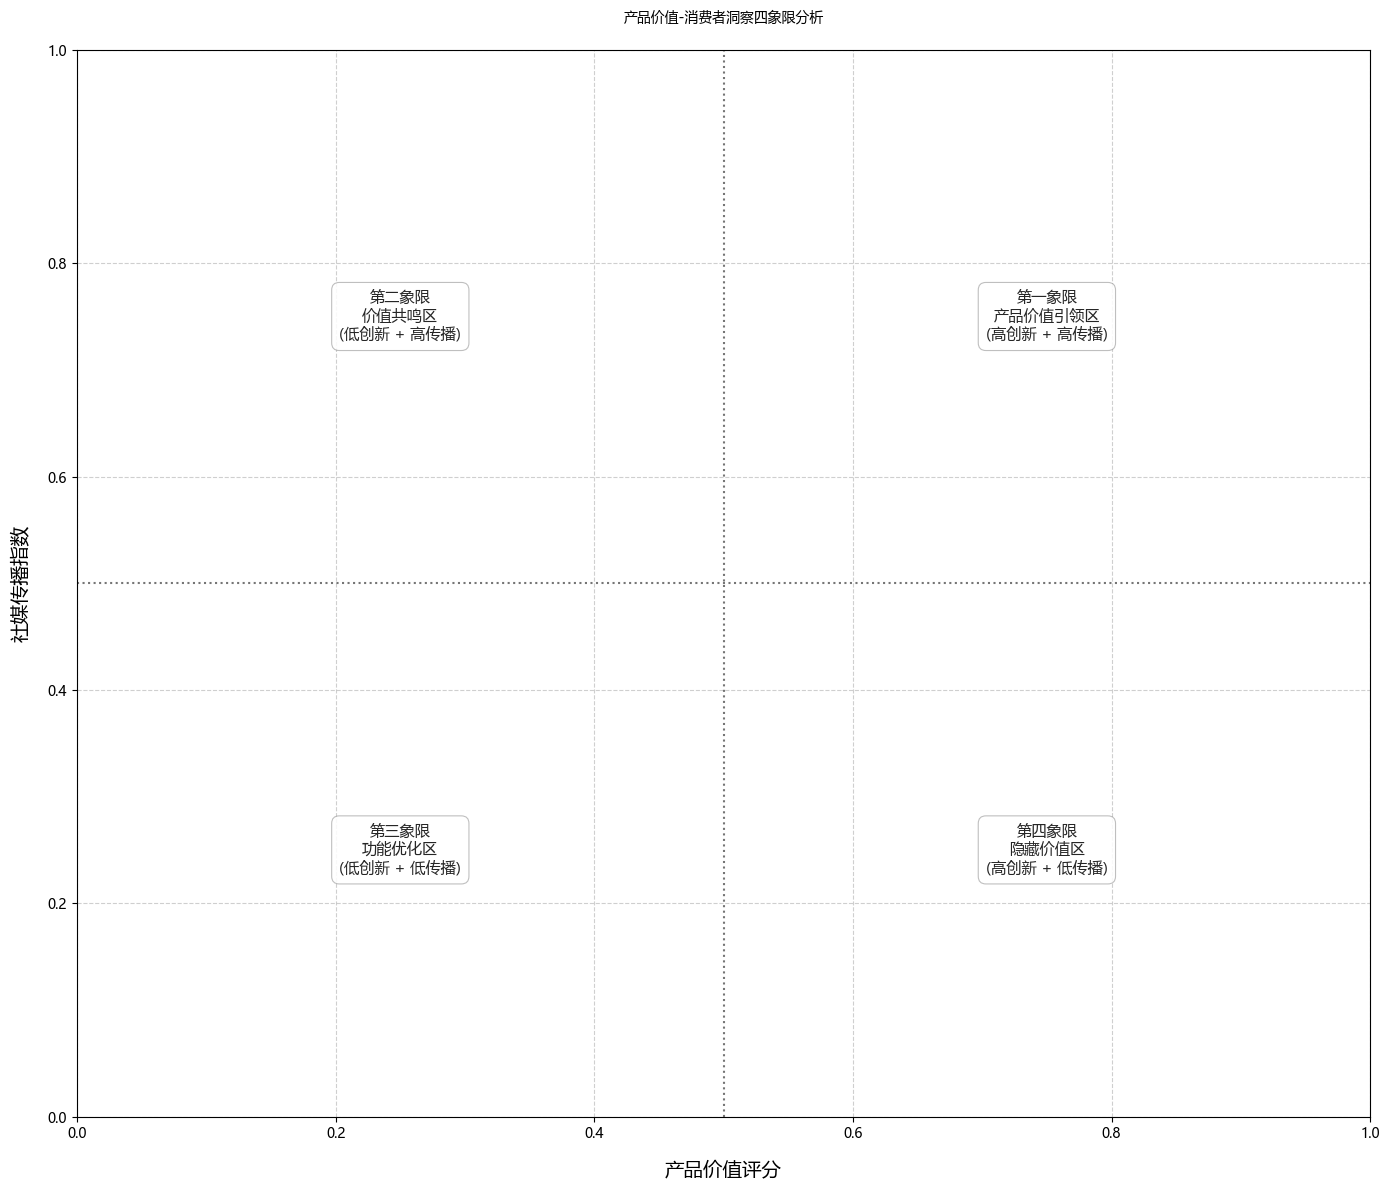

In [11]:
# 读取数据
voc_data = read_voc_data(voc_data_path)
social_media_model = read_social_media_model(social_media_model_path)

# 显示数据概览
if voc_data is not None:
    print("\nVOC数据概览:")
    if len(voc_data) > 0:
        print(voc_data.head())
        print("\nVOC数据统计:")
        print(voc_data.groupby('象限').size())
    else:
        print("VOC数据为空")

if social_media_model is not None:
    print("\n社交媒体模型结果概览:")
    print(social_media_model.head())
    print("\n显著变量:")
    print(social_media_model[social_media_model['显著性'] == '是'])

# 检查VOC数据是否为空
if voc_data is not None and len(voc_data) > 0:
    # 执行分析
    relationships_df = establish_matches_relationships(voc_data, social_media_model)
    results = calculate_coordinates(voc_data, relationships_df)
else:
    # 创建一个空的结果DataFrame，包含必要的列
    results = pd.DataFrame(columns=[
        '场景匹配', '场景匹配评分', '社媒传播指数', '综合得分', '文本质量', '提及频率'
    ])

# 保存结果到Excel
excel_path = os.path.join(sub_dir_path, '四象限数据-场景匹配.xlsx')
results.to_excel(excel_path, index=False)

# 绘制图表
plot_quadrant_chart(results)